# Data Loading

Note that we will encode a positive review as a 1 and a negative review as a 0.

In [1]:
import os
import pandas as pd
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
TRAIN_PATH = 'aclImdb/train'
TEST_PATH = 'aclImdb/test'

In [3]:
def data_read(path, train_or_test, pos_or_neg):
    reviews, labels = [], []
    
    for filename in os.listdir(path + '/' + pos_or_neg):
        with open(path + '/' + pos_or_neg + '/' + filename) as f:
            reviews.append(f.read())
        if pos_or_neg == 'pos':
            label = 1
        else:
            label = 0
        labels.append(label)
    
    return reviews, labels

In [4]:
pos_results = data_read(TRAIN_PATH, 'train', 'pos')
reviews = pos_results[0]
labels = pos_results[1]

neg_results = data_read(TRAIN_PATH, 'train', 'neg')
reviews += neg_results[0]
labels += neg_results[1]

In [5]:
train_df = pd.DataFrame({'reviews': reviews, 'y': labels})

In [6]:
train_df.head()

,reviews,y
0,For a movie that gets no respect there sure ar...,1
1,Bizarre horror movie filled with famous faces ...,1
2,"A solid, if unremarkable film. Matthau, as Ein...",1
3,It's a strange feeling to sit alone in a theat...,1
4,"You probably all already know this by now, but...",1


In [7]:
pos_results = data_read(TRAIN_PATH, 'test', 'pos')
reviews = pos_results[0]
labels = pos_results[1]

neg_results = data_read(TRAIN_PATH, 'test', 'neg')
reviews += neg_results[0]
labels += neg_results[1]

In [8]:
test_df = pd.DataFrame({'reviews': reviews, 'y': labels})

In [9]:
test_df.head()

,reviews,y
0,For a movie that gets no respect there sure ar...,1
1,Bizarre horror movie filled with famous faces ...,1
2,"A solid, if unremarkable film. Matthau, as Ein...",1
3,It's a strange feeling to sit alone in a theat...,1
4,"You probably all already know this by now, but...",1


In [10]:
test_df.tail()

,reviews,y
24995,"My comments may be a bit of a spoiler, for wha...",0
24996,"The ""saucy"" misadventures of four au pairs who...",0
24997,"Oh, those Italians! Assuming that movies about...",0
24998,Eight academy nominations? It's beyond belief....,0
24999,"Not that I dislike childrens movies, but this ...",0


# Pre-Processing

In [11]:
MAX_LENGTH = 15

UNK_token = 0
PAD_token = 1
SOS_token = 2
EOS_token = 3

In [12]:
class Voc(Dataset):
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: 'PAD', SOS_token: 'SOS', 
                           EOS_token: 'EOS', UNK_token: 'UNK'}
        self.num_words = 4 # include the ones above
        
    def add_sentence(self, sentence):
        for word in sentence.split():
            self.add_word(word.lower())
            
    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1
            
    # remove words that appear less frequently
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True
        keep_words = []
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)
        
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: 'PAD', SOS_token: 'SOS', 
                           EOS_token: 'EOS', UNK_token: 'UNK'}
        self.num_words = 4
        for word in keep_words:
            self.add_word(word)

# takes string sentence and returns sentence of word indices
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split()] + [EOS_token]

In [13]:
class ReviewDataset():
    def __init__(self, df):
        """Bad coding practice to use the globals but it will work for now"""
        self.reviews = df
        self.text = df['reviews']
        self.rating = df['y']
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        return (self.text[idx], self.rating[idx])

In [14]:
reviews = Voc('reviews')

In [15]:
for review in train_df['reviews']:
    reviews.add_sentence(review)

In [16]:
train_ds = ReviewDataset(train_df)
test_ds = ReviewDataset(test_df)

In [17]:
indexesFromSentence(reviews, 'hello world')

[22454, 562, 3]

In [18]:
train_dataloader = DataLoader(train_ds,
                              batch_size=1000,
                              shuffle=True, 
                              num_workers=4)

test_dataloader = DataLoader(test_ds,
                             batch_size=1000,
                             shuffle=True,
                             num_workers=4)

# Modeling

The Han model is going to fit a GRU, and for each word i in the sequence, we will collect the hidden layer $h_{i}$. Then for the attention model we have the following algorithm, for word $w_{t}$ in sentence of length T.

$$u_{t} = tanh(W_{w}h_{t} + b_{w})$$

$$\alpha_{t} = \frac{exp(u_{t}^{T}u_{w})}{\Sigma_{t}exp(u_{t}^{T}u_{w})}$$

$$s = \Sigma_{t} \alpha_{t}h_{t}$$

s is then input into a neural network for regression or classification.

In [19]:
class HAN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=60, hidden_size=15, num_layers=1, dropout=0.1):
        super(HAN, self).__init__()
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True,
                              dropout=(0 if num_layers==1 else dropout),
                              bidirectional=True)

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(2*hidden_size, 100)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(100, 1, bias=False)
        self.softmax = nn.Softmax(dim=1)
        self.fc3 = nn.Linear(2*hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_seq, input_lengths, hidden=None):
        # convert word indices to embeddings
        embedded = self.embedding(input_seq)
        
        # pass embeddings through GRU
        # all_layers is shape batch_size x max(sentence_length) x hidden_size*2
        all_layers, final = self.gru(embedded, hidden)

        # pass the hidden layers through linear layer
        # each word of each document will now be a length 100 tensor
        u = self.tanh( self.fc1(all_layers) )
        
        # map the length 100 tensor to a scalar representing importance
        # take the softmax to get the word importance WRT the document
        alpha = self.softmax( self.fc2(u) )
        
        # take sum of hidden layers for each sentence weighted by the alphas 
        s = (all_layers*alpha).sum(dim=1)
        
        # take the linear combination of hidden layers and 
        # plug into Linear Layer and Sigmoid to get probability
        s = self.sigmoid( self.fc3(s) )
        
        return s.squeeze(), alpha.squeeze() # will add alphas for visualization later

In [22]:
def train(model, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        losses = []
        
        for i, mails in enumerate(train_dataloader):
            # read in values from dataloader
            x = mails[0]
            y = mails[1]

            # index sentence and get lengths
            x = [sen.split() for sen in x]
            lengths = [len(sen) for sen in x]
            x = [[reviews.word2index.get(word, UNK_token) for word in sentence] for sentence in x]

            # create padded matrix
            batch_size = len(y)
            max_length = max(lengths)
            padded_x = np.ones((batch_size, max_length))*PAD_token
            for idx, x_len in enumerate(lengths):
                sequence = x[idx]
                padded_x[idx, 0:x_len] = sequence[:x_len]

            x = torch.Tensor(padded_x).long()
            y_hat, alpha = han(x, lengths)
            optimizer.zero_grad()
            
            loss = criterion(y_hat, y.float())
            loss.backward()
            optimizer.step()
            losses += [loss.item()]
            
        print(f'Train Loss after {epoch+1} epochs: {np.mean(losses)}')
        if epoch % 5 == 4:
            test(model)


def test(model):
    model.eval()
    losses, correct, total = [], 0, 0
    for i, mails in enumerate(test_dataloader):
        # read in values from dataloader
        x = mails[0]
        y = mails[1]

        # index sentence and get lengths
        x = [sen.split() for sen in x]
        lengths = [len(sen) for sen in x]
        x = [[reviews.word2index.get(word, UNK_token) for word in sentence] for sentence in x]

        # create padded matrix
        batch_size = len(y)
        max_length = max(lengths)
        
        padded_x = np.ones((batch_size, max_length))*PAD_token
        for idx, x_len in enumerate(lengths):
            sequence = x[idx]
            padded_x[idx, 0:x_len] = sequence[:x_len]

        x = torch.Tensor(padded_x).long()
        y_hat, _ = han(x, lengths)

        # cross-entropy
        loss = criterion(y_hat, y.float())
        losses += [loss.item()]
        
        # accuracy
        # print(y_hat == y)
        # correct += sum( y_hat == y )
        # total += y.shape.squeeze().tolist()
        
    print(f'Test Loss: {np.mean(losses)}\n')
    # print(f'Test Accuracy: {correct / total}')

# Training

In [23]:
V = len(reviews.index2word)
han = HAN(hidden_size=40, vocab_size=V, embedding_dim=50)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(han.parameters(), lr=0.01)

train(han, 20)

Train Loss after 1 epochs: 0.6949618887901307
Train Loss after 2 epochs: 0.692851722240448
Train Loss after 3 epochs: 0.659152762889862
Train Loss after 4 epochs: 0.5953547883033753
Train Loss after 5 epochs: 0.5722791266441345
Test Loss: 0.5506697940826416

Train Loss after 6 epochs: 0.5548452806472778
Train Loss after 7 epochs: 0.5488544297218323
Train Loss after 8 epochs: 0.5379242944717407
Train Loss after 9 epochs: 0.531576178073883
Train Loss after 10 epochs: 0.5282258319854737
Test Loss: 0.5240671873092652

Train Loss after 11 epochs: 0.5255982732772827
Train Loss after 12 epochs: 0.526283688545227
Train Loss after 13 epochs: 0.5244661664962769
Train Loss after 14 epochs: 0.5250935554504395
Train Loss after 15 epochs: 0.5236330819129944
Test Loss: 0.5193203473091126

Train Loss after 16 epochs: 0.5200687003135681
Train Loss after 17 epochs: 0.5187485384941101
Train Loss after 18 epochs: 0.5178194856643676
Train Loss after 19 epochs: 0.516795163154602
Train Loss after 20 epochs: 

In [24]:
torch.save(han.state_dict(), '/Users/jon_ross/Desktop/HAN_lower.pt')

TODO: Resume here by loading the model

In [55]:
V = len(reviews.index2word)
han = HAN(hidden_size=40, vocab_size=V, embedding_dim=50)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(han.parameters(), lr=0.01)

han.load_state_dict(torch.load('/Users/jon_ross/Desktop/HAN.pt'))
han.eval()

HAN(
  (embedding): Embedding(280621, 50)
  (gru): GRU(50, 40, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=80, out_features=100, bias=True)
  (tanh): Tanh()
  (fc2): Linear(in_features=100, out_features=1, bias=False)
  (softmax): Softmax()
  (fc3): Linear(in_features=80, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [26]:
train(han, 10)

Train Loss after 1 epochs: 0.5241520142555237
Train Loss after 2 epochs: 0.5224222278594971
Train Loss after 3 epochs: 0.5198068642616271
Train Loss after 4 epochs: 0.5182642269134522
Train Loss after 5 epochs: 0.5175112605094909
Test Loss: 0.5180205583572388

Train Loss after 6 epochs: 0.5177202367782593
Train Loss after 7 epochs: 0.5166498804092408
Train Loss after 8 epochs: 0.5163352775573731
Train Loss after 9 epochs: 0.5160267615318298
Train Loss after 10 epochs: 0.5221404814720154
Test Loss: 0.5192242956161499



In [27]:
torch.save(han.state_dict(), '/Users/jon_ross/Desktop/HAN.pt')

# Visualize Attention

In [26]:
import matplotlib.pyplot as plt
from matplotlib import transforms

def text_color(x, y, strings, colors, ax=None, **kw):   
    if ax is None:
        ax = plt.gca()
    t = ax.transData
    canvas = ax.figure.canvas

    # horizontal version
    for s, c in zip(strings, colors):
        text = ax.text(x, y, s + " ", color=(0.69-0.69*c,0.69-0.69*c,1), transform=t, **kw)
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        t = transforms.offset_copy(
            text.get_transform(), x=ex.width, units='dots')
        

def visualize_attention(sentence):
    sentence_tensor = torch.Tensor( [reviews.word2index[word] for word in sentence.split()] ).long()
    sentence_tensor = sentence_tensor.unsqueeze(dim=0)
    
    p, alpha = han( sentence_tensor, [len(sentence.split())] )
    print(f'Probability of positive review: {p}')
    
    text_color(0, 0, sentence.split(), alpha.tolist())
    plt.axis('off')

TODO: Unseen words are breaking the visualize function and I think it's because of the casing issues

Probability of positive review: 0.0004007560492027551


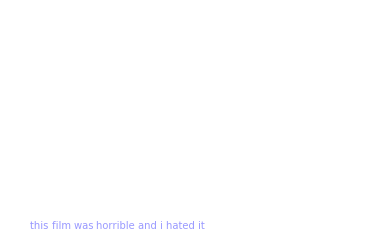

In [28]:
visualize_attention('this film was horrible and i hated it')

Probability of positive review: 0.9999785423278809


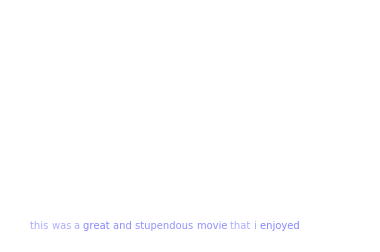

In [29]:
visualize_attention('this was a great and stupendous movie that i enjoyed')

Probability of positive review: 0.9995682835578918


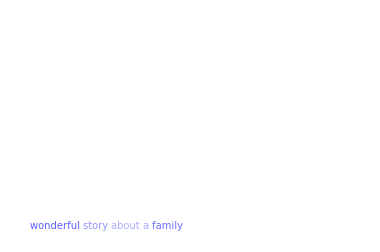

In [30]:
visualize_attention('wonderful story about a family')

Probability of positive review: 0.9546581506729126


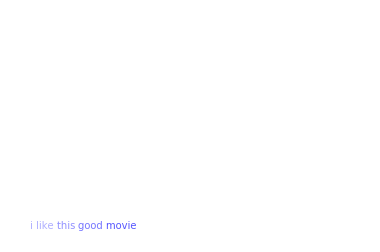

In [31]:
visualize_attention('i like this good movie')

Probability of positive review: 0.9996213912963867


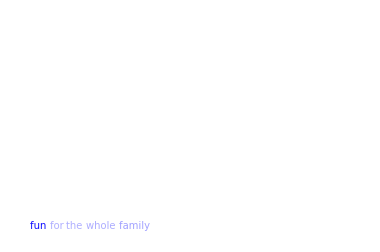

In [32]:
visualize_attention('fun for the whole family')

Probability of positive review: 4.977836397301871e-06


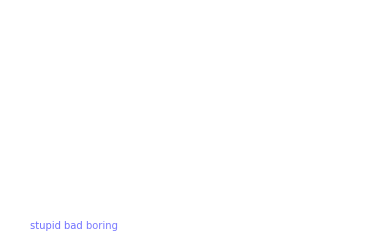

In [33]:
visualize_attention('stupid bad boring')

Probability of positive review: 0.0002521085843909532


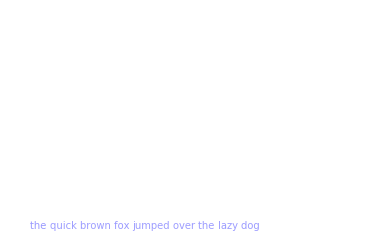

In [34]:
visualize_attention('the quick brown fox jumped over the lazy dog')

Probability of positive review: 0.9905688762664795


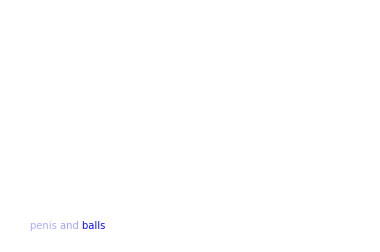

In [35]:
visualize_attention('penis and balls')

Probability of positive review: 0.5578060746192932


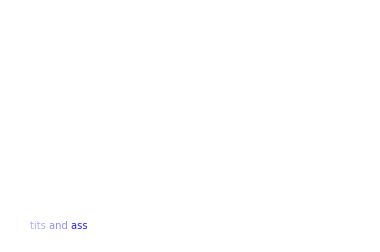

In [36]:
visualize_attention('tits and ass')

Probability of positive review: 0.020546400919556618


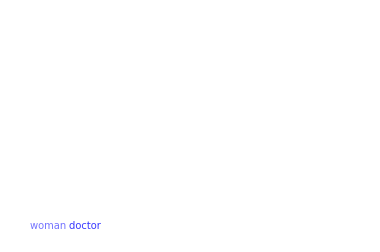

In [37]:
visualize_attention('woman doctor')

Probability of positive review: 0.7892389297485352


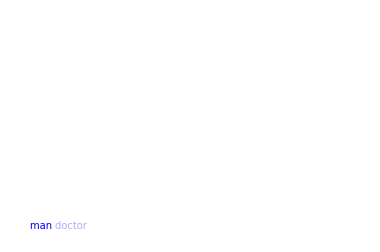

In [38]:
visualize_attention('man doctor')

Probability of positive review: 0.9541011452674866


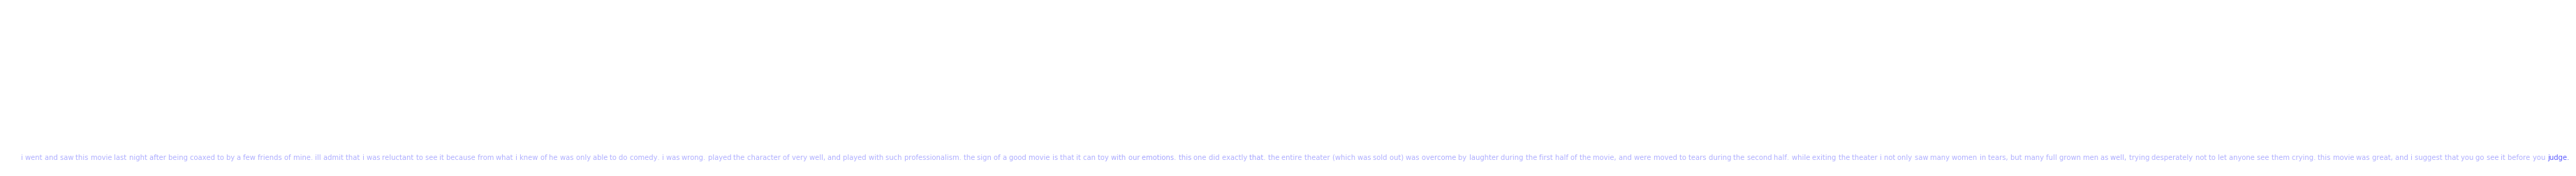

In [39]:
review = 'I went and saw this movie last night after being coaxed to by a few friends of mine. Ill admit that I was reluctant to see it because from what I knew of he was only able to do comedy. I was wrong.  played the character of  very well, and played with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.'
review = review.lower()

visualize_attention(review)

Probability of positive review: 0.003958775196224451


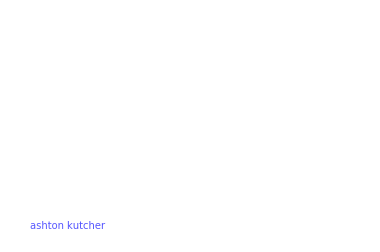

In [40]:
visualize_attention('ashton kutcher')